In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from darts.utils.missing_values import fill_missing_values
from darts import TimeSeries
import sys
from darts.metrics import rmse
from darts.dataprocessing.transformers import Scaler


# import seaborn as sns
# plt.style.use('default')

# sns.set_style()

df = pd.read_csv('../data/pro_train.csv', index_col=0, parse_dates= True)
val_df = df.loc[df.index.year > 2003]
def get_timeseries(df):
    series = TimeSeries.from_dataframe(df,freq = 'B') 
    series = fill_missing_values(series)
    return series


val = get_timeseries(val_df)
before_2003  =  df.loc[df.index.year < 2003]
train = get_timeseries(before_2003)

best_longer = pd.read_csv("../data/best_covs_longer.csv",index_col=0,parse_dates=True).drop(columns='time_as_number')
longer_covs = get_timeseries(best_longer)

<Axes: xlabel='Datum'>

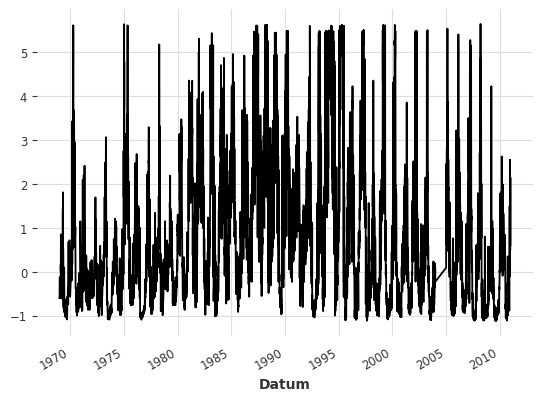

In [2]:
df.NOx.plot()

In [3]:

cols = ["SECCI","Temperatur","Salinität","NO3","NO2","NOx"]

In [4]:
from sklearn.ensemble import GradientBoostingRegressor
val_df = df.loc[(df.index.year == 2005) | (df.index.year == 2006)][cols]
train_df = df.loc[df.index.year > 2006][cols]

val_x = val_df.iloc[:,:5]
val_y = val_df.NOx
train_x =  train_df.iloc[:,:5]
train_y = train_df.NOx


switcher = GradientBoostingRegressor(random_state=0
)

switcher.fit(train_x,train_y)

vals = switcher.predict(val_x)
np.sqrt(np.mean(np.square(vals - val_y)))

0.05781493522554415

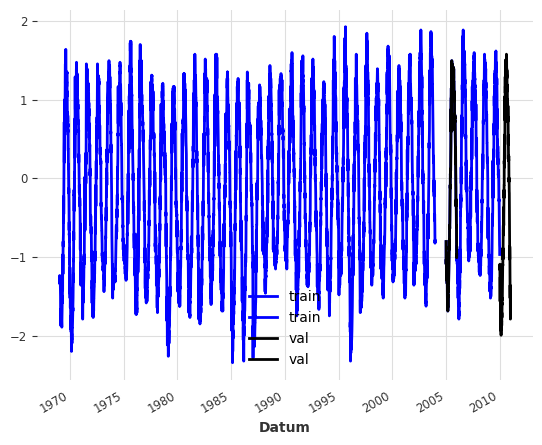

In [5]:
before_train = df.loc[df.index.year < 2004].copy().iloc[3:]

data_df = df.iloc[3:].copy()

data_df.loc[data_df.index.year < 2004,'NOx'] = switcher.predict(data_df.loc[data_df.index.year < 2004,cols].drop(columns = "NOx"))

train1_a = get_timeseries(data_df.loc[ (data_df.index.year <= 2003)])
train1_l = get_timeseries(data_df.loc[ (data_df.index.year <= 2003)])
train2 = get_timeseries(data_df.loc[(data_df.index.year > 2004) & (data_df.index.year <= 2009)])

val1 =  get_timeseries(data_df.loc[data_df.index.year == 2005])
val2 =  get_timeseries(data_df.loc[data_df.index.year == 2010])

train1_a['Temperatur'].plot(label = "train",c = "blue")
train2['Temperatur'].plot(label = "train",c = "blue")
val1['Temperatur'].plot(label = "val", c= "black")
val2['Temperatur'].plot(label = "val", c= "black")

In [6]:
import json
with  open("../data/best_lgb.json","r") as f:
  lgm_params = json.load(f)
lgm_params

{'in_len': 6.0,
 'out_len': 5.0,
 'lags_lower': 5.0,
 'upper_lag': 8.0,
 'n_estimators': 325.0,
 'max_depth': 11.0,
 'learning_rate': 0.1419024663,
 'num_leaves': 1879.0,
 'min_data_in_leaf': 28.0,
 'lambda_l1': 7.0,
 'lambda_l2': 85.0,
 'min_gain_to_split': 1.3044759378,
 'bagging_fraction': 0.7,
 'bagging_freq': 1.0,
 'feature_fraction': 0.3}

In [7]:
from darts.models.forecasting.lgbm import LightGBMModel

def best_light(all = False):
    params = lgm_params.copy()
    in_len = int(params.pop('in_len'))
    out_len = int(params.pop("out_len"))


    lags_lower = int(params.pop("lags_lower")) 
    lags_upper = int(params.pop("upper_lag"))

    if not all:

        return LightGBMModel(lags = in_len,
                            lags_future_covariates = (lags_lower,lags_upper),
                            output_chunk_length=out_len, random_state = 0
                            )
    n_estimators = int(params.pop('n_estimators'))
    num_leaves = int(params.pop('num_leaves'))
    max_depth = int(params.pop('max_depth'))
    min_data_in_leaf = int(params.pop('min_data_in_leaf'))
    bagging_freq = int(params.pop('bagging_freq'))
        
    return LightGBMModel(lags = in_len,
                        lags_future_covariates = (lags_lower,lags_upper),
                        output_chunk_length=out_len, n_estimators = n_estimators,
                        num_leaves = num_leaves,
                        bagging_freq = bagging_freq,
                        min_data_in_leaf = min_data_in_leaf,
                        max_depth = max_depth,
                     random_state = 0,
                        **params
                        )

/home/felix/anaconda3/envs/bbdc/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [8]:
from darts.models.forecasting.xgboost import XGBModel

params = {'learning_rate': 0.07014188001597053, 'max_depth': 4, 'gamma': 1.0518764146499875, 'reg_alpha': 0.0070217178903161925, 'reg_lambda': 0.2538094460672119, 'colsample_bytree': 0.6221196927178515, 'min_child_weight': 10, 'n_estimators': 294, 'in_len': 14, 'out_len': 3, 'lags_lower': 11, 'upper_lag': 9}
def best_xgm_model(multi_models = True):
    global params
    ps = params.copy()
    in_len = ps.pop('in_len')
    out_len = ps.pop("out_len")


    lags_lower = ps.pop("lags_lower") 
    lags_upper = ps.pop("upper_lag") 
    return XGBModel(lags = in_len,
                        lags_future_covariates = (lags_lower,lags_upper),
                        output_chunk_length=out_len, 
                        seed = 0,
                        # tree_method = 'gpu_hist',
                        **ps, multi_models=multi_models)
    
from darts.metrics import mse
def train_cols(model,columns,cov,train1):
    model.fit([train1[columns],train2[columns]],future_covariates=[cov,cov])
    
    preds1 = model.predict(550,train1[columns],future_covariates=cov)
    preds2 = model.predict(500,train2[columns],future_covariates=cov)
    
    loss1 = mse(val1[columns],preds1)
    
    loss2 = mse(val2[columns],preds2)
    loss = np.sqrt((loss1 + loss2)/2)
    
    for c in columns:
        l1 = mse(val1[c],preds1[c])
        l2 = mse(val2[c],preds2[c])
        l = np.sqrt((l1 + l2)/ 2)
        
        # preds2[c].plot(label= 'predict')
        # val2[c].plot(label='actual')
        print(f"{c} - {l}")
        # plt.suptitle(f"{c} - {l}")
        # preds1[c].plot(label= 'predict')
        # val1[c].plot(label='actual')
        # plt.show()
    
    return loss, 

In [9]:
best = {("Temperatur",) : ("Temperatur","SECCI",train1_a)}

best[('NO2', 'NO3', 'NOx',)] = ('NO2', 'NO3', 'NOx','SiO4',train1_l)
best[('PO4','SiO4','NH4')] = ('NO2', 'NO3', 'NOx', 'NH4', 'PO4', 'SiO4',train1_l)


def extract_cols(train_columns,extract_column,train1):
    model = best_light()
    train_columns = list(train_columns)
    extract_column = list(extract_column)
    
    model.fit([train1[train_columns],train2[train_columns]],future_covariates=[longer_covs,longer_covs])
    
    preds1 = model.predict(600,train1[train_columns],future_covariates=longer_covs).pd_dataframe()
    
    
    preds2 = model.predict(1500,val2[train_columns],future_covariates=longer_covs).pd_dataframe()
    
    df = pd.concat((preds1,preds2))[extract_column]
    if isinstance(df,pd.Series):
        df = df.to_frame()
    return df
    
    

import tqdm

preds = []

for label, t in tqdm.tqdm(best.items()):

    t1 = t[-1]

    preds.append(extract_cols(list(t[:-1]),list(label),t1))


100%|██████████| 3/3 [00:54<00:00, 18.01s/it]


In [10]:
import os

if not os.path.exists("profesional_submission.csv"):
    
    pd.read_csv("../data/bbdc_prof/bbdc_2023_AWI_data_evaluate_skeleton_professional.csv",delimiter=';').to_csv("profesional_submission.csv",sep = ';',index= False)

In [11]:
submission_ds = pd.read_csv('profesional_submission.csv', delimiter=';',skiprows=[1])
submission_ds.index = pd.to_datetime(submission_ds.Datum,format='%d.%m.%Y')

ps = pd.concat(preds,axis = 1)

submission_ds[ps.columns] = ps.loc[submission_ds.index]


columns= ['SECCI', 'Temperatur', 'Salinität', 'SiO4', 'PO4', 'NO2', 'NO3', 'NOx', 'NH4']
means = [ 3.69384615,10.81260073,32.34811062,6.81071795,0.58017582,0.52419048,8.89443223,9.41987546,1.72098901]
variance =  [ 3.32627715,23.66155551,1.01593854,20.60446425,0.14762077,0.46926596,68.50472915,71.50321661,2.25913682]
means = pd.Series(means,index = columns)
stds  = pd.Series(np.sqrt(variance),index = columns)

for col in ps.columns:
    print(col)
    if col in means.index:
        
        submission_ds[col] = (submission_ds[col] * stds[col]) + means[col]

Temperatur
NO2
NO3
NOx
PO4
SiO4
NH4


In [12]:
submission_ds.to_csv('profesional_submission.csv',sep = ';',index= False)
with open("../data/bbdc_prof/bbdc_2023_AWI_data_evaluate_skeleton_professional.csv","r") as f:
    metrics = f.read().splitlines()[1]
with open('profesional_submission.csv',"r") as f:
    lines = f.read().splitlines()
lines.insert(1,metrics)


with open('profesional_submission.csv',"w") as f:
    f.write("\n".join(lines))